In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy as sp
import scipy.stats
import seaborn as sns
from matplotlib import cm
import networkx as nx
# Using matplotlib notebook allows you to interact with the resulting 3-D figure
%matplotlib inline

### Create the 3D Mesh and its Triangulation

First create a 2D x-y mesh

In [2]:
edge = 0.6
# x and y are the corresponding indices of a 2D mesh
x, y = np.mgrid[-edge:edge:.05, -edge:edge:.05]
# create the structure needed for evaluating pdfs
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
gridsize = x.shape[0]

Next define the two "bumps" to determine the 3rd dimension for each point

In [3]:
var1 = 0.02
var2 = 0.02
loc1 = [0.25, 0.25]
loc2 = [-0.25, -0.25]
height1 = 0.1
height2 = 0.03
rv1 = sp.stats.multivariate_normal(loc1, [[var1, 0], [0, var1]])
rv2 = sp.stats.multivariate_normal(loc2, [[var2, 0], [0, var2]])
z = height1 * rv1.pdf(pos) + height2 * rv2.pdf(pos)

Now create the triangulation of the 3D mesh

In [4]:
# we compute the triangulation explicitly so as to 
# have complete control over it 
def coord_to_ndx(i, j):
    return i*gridsize + j

def ndx_to_coord(b):
    return [(b // gridsize), (b % gridsize)]

# each square in the mesh is divided into two triangles
def triang1(i, j):
    return [coord_to_ndx(i, j), coord_to_ndx(i+1, j),
                coord_to_ndx(i, j+1)]

def triang2(i, j):
    return [coord_to_ndx(i+1, j), coord_to_ndx(i+1, j+1),
                coord_to_ndx(i, j+1)]

# create this mesh as a graph as well, for later use in Laplacian smoothing
G = nx.Graph()
for i in range(gridsize):
    for j in range(gridsize):
        G.add_node(coord_to_ndx(i, j), pos=(i,j))
        
for i in range(gridsize-1):
    for j in range(gridsize-1):
        G.add_edge(coord_to_ndx(i, j), coord_to_ndx(i+1, j))
        G.add_edge(coord_to_ndx(i, j), coord_to_ndx(i, j+1))

for i in range(1, gridsize):
    for j in range(gridsize-1):
        G.add_edge(coord_to_ndx(i, j), coord_to_ndx(i-1, j+1))

# Note: these edges are not in the triangulation
# However for regularization they are useful to get symmetric regularization
for i in range(1, gridsize):
    for j in range(1, gridsize):
        G.add_edge(coord_to_ndx(i, j), coord_to_ndx(i-1, j-1))
for j in range(gridsize-1):
    G.add_edge(coord_to_ndx(gridsize-1, j), coord_to_ndx(gridsize-1, j+1))
for i in range(gridsize-1):
    G.add_edge(coord_to_ndx(i, gridsize-1), coord_to_ndx(i+1, gridsize-1))

# triangles is a list of 3-tuples
# each 3-tuple consists of the index of the triangle's vertices
triangles = []
for i in range(gridsize-1):
    for j in range(gridsize-1):
        triangles.append(triang1(i,j))
        triangles.append(triang2(i,j))  

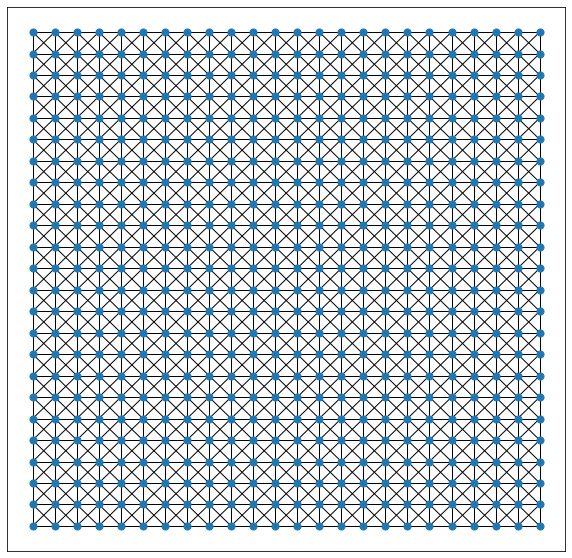

In [5]:
pos_dict = {}
node_data = G.nodes(data=True)
for n in G.nodes():
    pos_dict[n] = np.array(node_data[n]['pos'])

plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=pos_dict, node_size = 50, with_labels=False)

In [6]:
L = nx.laplacian_matrix(G).todense()

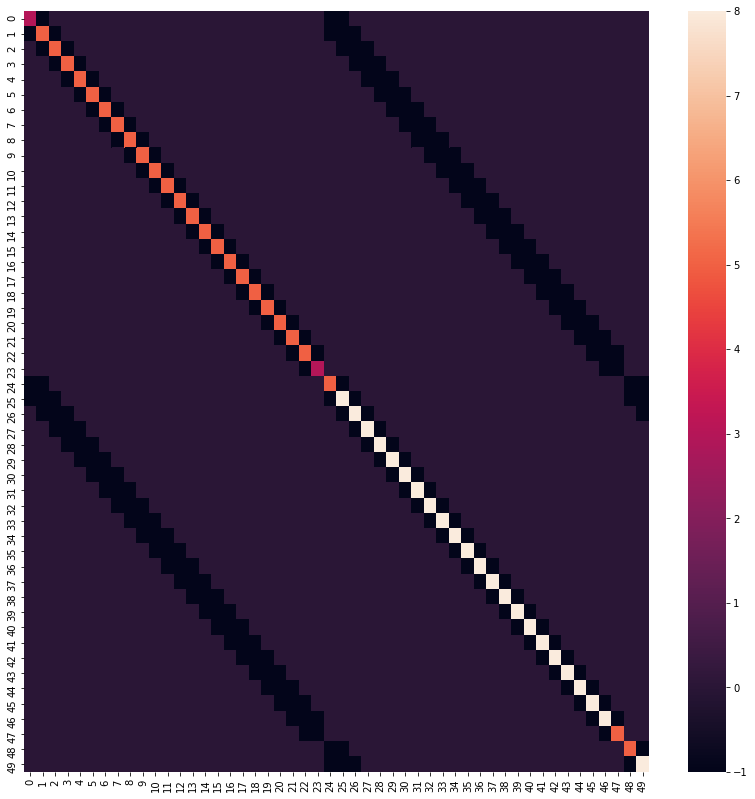

In [7]:
plt.figure(figsize=(14,14))
sns.heatmap(L[:50,:50])

In [8]:
xf = x.flatten()
yf = y.flatten()
zf = z.flatten()

In [9]:
# this is the actual mesh we will plot
triangle_vertices = np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
# vertices is the list of coordinates of each triangle
vertices = np.array(list(zip(xf, yf, zf)))

In [10]:
def viz(triangle_vertices, facecolors):

    # plot the triangle mesh
    coll = Poly3DCollection(triangle_vertices, facecolors=facecolors, linewidth=0.1,
                        edgecolors='gray')

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.add_collection(coll)
    ax.view_init(elev=0, azim=135)

    plt.axis('off')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.elev = 50
    return ax

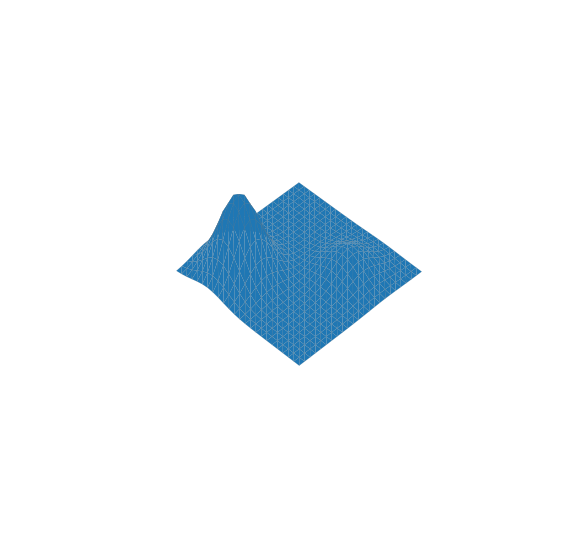

In [11]:
viz(triangle_vertices, None)

### Color the mesh according to curvature

__Basic idea of how to color the mesh:__

1. For each vertex, get all adjacent triangles
    * For each triangle, compute its angle at that vertex
    * Then sum all angles to compute the local curvature at that vertex
3. For each triangle, compute average curvature of its vertices
4. Color the triangle according to the average curvature of its vertices

__Geometry:__

Given a triangle with vertices $p_0, p_1, p_2$.   Assume you want to compute the angle at vertex $p_0$.

Let $v = p_1 - p_0,$ $u = p_2 - p_0$.  Then $\theta = \cos^{-1}\frac{u^T v}{\Vert u\Vert \Vert v\Vert}$

#### Find all triangles for each vertex

In [12]:
def triangles_of_vertex(triangles):
    '''
    triangles is a list of triangles (indices)
    return a dictionary giving the triangles for any vertex
    '''
    t_of_v = {}
    for T in triangles:
        for pt in T:
            if pt in t_of_v:
                t_of_v[pt].append(T)
            else:
                t_of_v[pt] = [T]
    return t_of_v

#### Compute the angle of vertex $b$ in triangle $T$

In [13]:
def angle_of_b_in_t(b, T, vertices):
    '''
    for a vertex b which is an index into vertices
    and a triangle T (which is a triple)
    return the angle formed by the two triangles sides at vertex b
    '''
    others = [t for t in T if t != b]
    u = np.array(vertices[others[0]] - vertices[b])
    v = np.array(vertices[others[1]] - vertices[b])
    return np.arccos((u.T @ v) / (np.linalg.norm(u) * np.linalg.norm(v)))

#### Compute the curvature at vertex $b$.

The curvature at a vertex $= 2 \pi - \sum$ angles around vertex

In [14]:
def vertex_curvature(b, t_of_v, vertices):
    # find the angles of the edges incident at each vertex b
    # t_of_v[b] is the set of triangles incident to vertex b
    angles = [angle_of_b_in_t(b, t, vertices) for t in t_of_v[b]]
    if len(angles) == 6:
        # this is an interior vertex
        return 2 * np.pi - np.sum(angles)
    #elif len(angles) == 3:
        #return np.pi - np.sum(angles)
    #elif len(angles) == 2:
        #return (np.pi / 2) - np.sum(angles)
    #elif len(angles) == 1:
        #return (np.pi / 2) - np.sum(angles)
    else:
        # this vertex does not have the standard number of neighbors (6)
        # which happens at the edge of the mesh
        # so just ignore it - will be filtered out of the visualization
        return np.nan 

Apply the above functions to compute the curvature at each vertex

In [15]:
t_of_v = triangles_of_vertex(triangles)
cv = np.array([vertex_curvature(v, t_of_v, vertices) for v in range(len(vertices))])

In [16]:
t_of_v[44]

[[43, 44, 20],
 [20, 44, 21],
 [44, 45, 21],
 [43, 67, 44],
 [67, 68, 44],
 [44, 68, 45]]

Let's get a sense of the range of values of curvature observed

/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


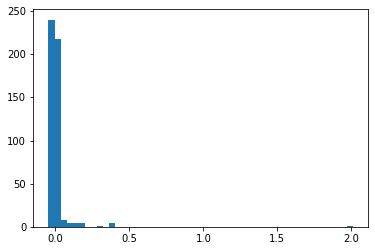

In [17]:
plt.figure()
plt.hist(cv,bins=50);

Compute the average curvature for each triangle

In [18]:
pcv = np.array([np.nanmean(cv[triangles[t]]) for t in range(len(triangles))])

/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


#### Visualize

Given the above histogram, the small number of points with very large curvature will distort the scale and hide the variation of curvature around zero.   So we artificially clamp all values above a threshold, and rescale the values close to zero so they can be seen.

/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


max curvature is 0.9236235712194585
min curvature is -0.046461401701605176


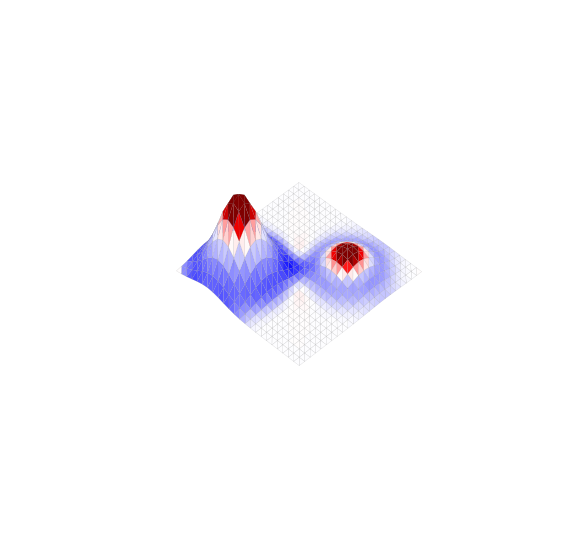

In [19]:
cmap = cm.seismic
print('max curvature is', np.nanmax(pcv))
print('min curvature is', np.nanmin(pcv))

# for visualization, concentrate on intermediate curvature values
# only visualize cuvatures in range [-maxscale, maxscale]
# all other values are set to maxscale or -maxscale
maxscale = .1

# first, set all values above maxscale to maxscale 
pcv[pcv > maxscale] = maxscale
pcv[pcv < -maxscale] = -maxscale

def rmap(x, oldmin, newmin, oldmax, newmax, newzero):
    '''
    linear rescaling for visualization purposes
    rescale from range [oldmin, 0] to [newmin, newzero]
    and from [0, oldmax] to [newzero, newmax]
    '''
    if x > 0:
        return (x/oldmax)*(newmax-newzero)+newzero
    elif x < 0:
        return (x/oldmin)*(newmin-newzero)+newzero
    else:
        return newzero
    
# remap values and compute colors of each triangle
facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])

viz(triangle_vertices, facecolors);

In [20]:
var1 = 0.02
var2 = 0.02
loc1 = [0.25, 0.25]
loc2 = [-0.25, -0.25]
height1 = 0.1
height2 = 0.2
rv1 = sp.stats.multivariate_normal(loc1, [[var1, 0], [0, var1]])
rv2 = sp.stats.multivariate_normal(loc2, [[var2, 0], [0, var2]])
z = height1 * rv1.pdf(pos) + height2 * rv2.pdf(pos)

In [21]:
zf = z.flatten()
# this is the actual mesh we will plot
triangle_vertices = np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
# vertices is the list of coordinates of each triangle
vertices = np.array(list(zip(xf, yf, zf)))
cv = np.array([vertex_curvature(v, triangles_of_vertex(triangles), vertices) for v in range(len(vertices))])
pcv = np.array([np.nanmean(cv[triangles[t]]) for t in range(len(triangles))])

/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


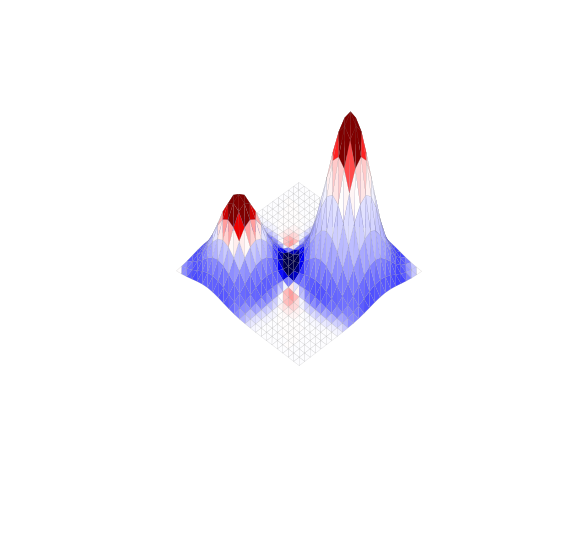

In [22]:
# for visualization, concentrate on intermediate curvature values
# only visualize cuvatures in range [-maxscale, maxscale]
# all other values are set to maxscale or -maxscale
maxscale = .1

# first, set all values above maxscale to maxscale 
pcv[pcv > maxscale] = maxscale
pcv[pcv < -maxscale] = -maxscale

# remap values and compute colors of each triangle
facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])

viz(triangle_vertices, facecolors);

## Warping a surface to match a curvature

### Build a test case

Get a curvature value for each point

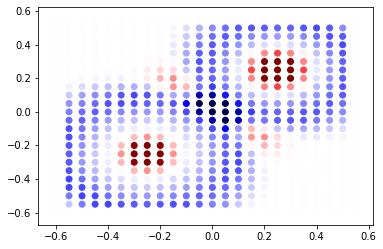

In [23]:
plt.scatter(xf, yf, color = [cmap(rmap(p, -maxscale, 0, maxscale, 1, 0.5)) for p in cv])

### Loss Function

Let the intended curvature at grid point $i$ be $\kappa(i)$ and the current curvature be $c(i)$.   Then to match the observed curvature, the objective function is:

$$ \mathcal{L} = \sum_i (\kappa(i) - c(i))^2. $$

Each point has three coordinates, ie, $a = (x_a, y_a, z_a)$.  In order to use gradient descent to minimize this loss function we need to compute
$$ \frac{\partial \mathcal{L}}{\partial z} $$
where $z = [z_i]^T$.  Written out, the above is $[\frac{\partial \mathcal{L}}{\partial z_i}]^T$.

### Symmetry breaking

However, note that there is a symmetry-breaking problem here.  From a starting point of a flat surface, we can get positive curvature at $i$ by moving $i_z$ either upwards or downwards.  

Without some correction, this get manifested by creation of adjacent convex and concave regions within the positively curved region.   We get rings of peaks and valleys.

Basic fact:  $x^TLx = \sum_{(u,v)\in E} (x(u) - x(v))^2.$

#### Option 0: Smoothness

Penalize $z^TLz$.  This will reduce "high frequency" variation in the z coordinate.

This seems to work well.  It removes the symmetry-breaking problem at small scales.  

However, peaks can be either negative or positive in general -- symmetry breaks badly at large scales.

Hence, need initialization of $z$ using $\kappa$.

#### Option 1: First derivative smoothness

Penalize variation in local gradient.  As much as possible, each node should be the average of its neighbors.  

This can be accomplished by penalizing:

$$  \sum_ i \left(\sum_{j \in N(i)} (i_z - j_z)\right)^2. $$

where $N(i)$ are the neighbors of $i$.

Expressed using $L$, the Laplacian of the mesh graph:

$$ z^TL^2z. $$

Does not work well -- essentially, works exactly oppositely of main goal, meaning it seeks a flat surface.

#### Option 2: consistent convexity (second derivative smoothness)

Another way to address this is by breaking the symmetry of curvature: penalize adjacency of convex and concave regions.

The concavity $r(v)$ at a node $v$  is $Lz(v)$.  If this value is positive, the region is concave (opening downward).

We want this to be locally smooth, ie, we want to penalize $z^TL^3z$.

This works best of all the above, when combined with initialization of $z$ using $\kappa$.

#### Option p: penalize negative convexity in positively curved regions

The concavity $r(v)$ at a node $v$  is $Lz(v)$.  If this value is positive, the region is concave (opening downward).

So, want to penalize negative values of $Lz$ at points where curvature ($\kappa$) is positive.
This can be expressed as hinge loss applied only in positively curved regions.

$\mathcal{L}_h = h(r(v))$ if $\kappa(v) > 0$, where $h$ is hinge loss function: $h(x) = x$ if $x > 0$, $0$ otherwise.

So $dh/dx = 1$ if $x > 0$, $0$ otherwise.

So $\frac{\partial\mathcal{L}_h}{dz} = \frac{\partial h}{\partial r} \cdot \frac{\partial r}{\partial z} = -Lz(v)$ if $\kappa(v) > 0$ and $Lz(v) < 0$.

### Gradient

The gradient we seek is:
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) $$
    
(which could be 
    $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) + \lambda \frac{\partial f}{\partial z}$$
   if we want to smooth the curvature using one of the above penalizations $f(z)$.)

The curvature at grid point $i$ is
$$ c(i) = 2\pi - \sum_{t\in T(i)} \alpha(t, i)$$ 
where $T(i)$ is the set of triangles that meet at grid point $i$ and $\alpha(t, i)$ is the interior angle of triangle $t$ at grid point $i$.

So $$ \frac{\partial \mathcal{L}}{\partial z} = \sum_i 2(\kappa(i) - c(i))\left(-\frac{\partial c(i)}{\partial z}\right) = \sum_i 2(\kappa(i) - c(i)) \sum_{t\in T(i)} \frac{\partial \alpha(t, i)}{\partial z} $$

For a triangle $t = (a, b, c)$, if we want the angle at $b$, we have by the law of cosines:
$$ \alpha(t, b) = \cos^{-1}\frac{u^T v}{\Vert u\Vert \Vert v\Vert}$$
where $v = a - b,$ $u = c - b$. 

Expanding this out:
    $$ \alpha(t, b) = \cos^{-1}\frac{(c-b)^T (a-b)}{\sqrt{(c-b)^T(c-b)}\sqrt{(a-b)^T(a-b)}}$$

Let $w  = \frac{(c-b)^T (a-b)}{(c-b)^T(c-b) (a-b)^T(a-b)}$.  Then the above is

$$ \alpha(t, b) = \cos^{-1} w $$

and 

$$ \frac{\partial \alpha(t, b)}{\partial z} = - \frac{1}{\sqrt{1 - w^2}} \frac{\partial w}{\partial z} $$

Expanding further:
    
$$w  = \frac{(c-b)^T (a-b)}{\sqrt{(c-b)^T(c-b)}\sqrt{(a-b)^T(a-b)}} = \frac{c^Ta-c^Tb-b^Ta+b^Tb}{\sqrt{(c^Tc-2b^Tc+b^Tb)}\sqrt{(a^Ta-2a^Tb+b^Tb)}} = \frac{f(z)}{g(z)}.$$

By the quotient rule:
$$ \frac{\partial w}{\partial z} = \frac{g(z) \frac{\partial f}{\partial z} - f(z) \frac{\partial g}{\partial z}}{g^2(z)}$$

For clarity let's break $g(z)$ into $p(z)q(z)$.

$$ \frac{\partial g}{\partial z} = p(z) \frac{\partial q}{\partial z} + q(z) \frac{\partial p}{\partial z}$$

with

$$\frac{\partial p}{\partial z} = \frac{(c^Tc)'-(2b^Tc)'+(b^Tb)'}{2\sqrt{(c^Tc-2b^Tc+b^Tb)}} $$

and 

$$\frac{\partial q}{\partial z} = \frac{(a^Ta)'-(2a^Tb)'+(b^Tb)'}{2\sqrt{(a^Ta-2a^Tb+b^Tb)}}$$

Now $ \frac{\partial a^Tb}{\partial z} $
is a vector with $a_z$ in position $b$, $b_z$ in position $a$, and zeros elsewhere.   Likewise $ \frac{\partial a^Ta}{\partial z} $ is a vector with $2a_z$ in position $a$.

Let us use $(a^Tb)'$ to denote $ \frac{\partial a^Tb}{\partial z} $.   Then

$$ \frac{\partial f}{\partial z} = (c^Ta)'-(c^Tb)'-(b^Ta)'+(b^Tb)' $$

is a vector with $(a_z-b_z)$ in position $c$, $(2b_z - a_z - c_z)$ in position $b$, and $(c_z-b_z)$ in position $a$.

Likewise, 
$$ \frac{\partial g}{\partial z} = \sqrt{c^Tc-2b^Tc+b^Tb} \cdot \frac{(a^Ta)'-(2a^Tb)'+(b^Tb)')}{2 \sqrt{a^Ta-2a^Tb+b^Tb}} +\sqrt{a^Ta-2a^Tb+b^Tb} \cdot \frac{(c^Tc)'-2(b^Tc)'+(b^Tb)'}{2\sqrt{c^Tc-2b^Tc+b^Tb}} $$

To evaluate the above it is helpful to note that if $h = (a-b)^T(a-b)$, then

$$ \frac{\partial h}{\partial z} = (a^Ta)' - 2(a^Tb)' + (b^Tb)'$$

which is a vector with $(2a_z - 2b_z)$ in position $a$, and $(2b_z - 2a_z)$ in position $b$.

And we have all the pieces to put together the gradient that we need.

### Functions for computing gradient

Let `apos` be the 1D index of `a`, where `a` is $(a_x, a_y, a_z)$

In [24]:
def df_dz (n, a, apos, b, bpos, c, cpos):
    '''
    partial f / partial z
    f = (c-b)^T (a-b)
    apos is the index of a into the 1D grid vector
    a is [a_x, a_y, a_z]
    '''
    gr = np.zeros(n)
    gr[apos] = c[2] - b[2]
    gr[bpos] = (2 * b[2]) - a[2] - c[2]
    gr[cpos] = a[2] - b[2]
    return gr

def dh_dz(n, a, apos, b, bpos):
    '''
    partial h / partial z
    f = (a-b)^T (a-b)
    apos is the index of a into the 1D grid vector
    a is [a_x, a_y, a_z]
    '''
    gr = np.zeros(n)
    gr[apos] = 2 * (a[2] - b[2])
    gr[bpos] = 2 * (b[2] - a[2])
    return gr

def fz(a, b, c):
    return (c - b).T @ (a - b)

def pz(a, b, c):
    return np.sqrt((c - b).T @ (c - b))

def qz(a, b, c):
    return np.sqrt((a - b).T @ (a - b))

def gz(a, b, c):
    return pz(a, b, c) * qz(a, b, c)

def wz(a, b, c):
    return fz(a, b, c) / gz(a, b, c)

def dq_dz(n, a, apos, b, bpos, c, cpos):
    return dh_dz(n, a, apos, b, bpos) / (2 * qz(a, b, c))
    
def dp_dz(n, a, apos, b, bpos, c, cpos):
    return dh_dz(n, c, cpos, b, bpos) / (2 * pz(a, b, c))

def dg_dz(n, a, apos, b, bpos, c, cpos):
    '''
    partial g / partial z
    g = sqrt((c-b)^(c-b)) * sqrt((a-b)^(a-b))
    apos is the index of a into the 1D grid vector
    a is [a_x, a_y, a_z]
    '''
    gr = pz(a, b, c) * dq_dz(n, a, apos, b, bpos, c, cpos) + qz(a, b, c) * dp_dz(n, a, apos, b, bpos, c, cpos)
    return gr

def dw_dz(n, a, apos, b, bpos, c, cpos):
    return ((gz(a, b, c) * df_dz(n, a, apos, b, bpos, c, cpos)) 
            - (fz(a, b, c) * dg_dz(n, a, apos, b, bpos, c, cpos))) / (gz(a, b, c) * gz(a, b, c))

def dalpha_dz(n, a, apos, b, bpos, c, cpos):
    '''
    partial alpha / partial z
    alpha is angle at vertex b defined by triangle (a, b, c)
    '''
    wzval = wz(a, b, c)
    return - (1/np.sqrt(1 - (wzval * wzval))) * dw_dz(n, a, apos, b, bpos, c, cpos)

In [25]:
dalpha_dz(10, np.array([1, 1, 4]), 3, np.array([1, 3, 3]), 4, np.array([3, 3, 4]), 5)

array([-0.        , -0.        , -0.        , -0.16329932,  0.32659863,
       -0.16329932, -0.        , -0.        , -0.        , -0.        ])

In [26]:
# test case
kappa = cv.copy()

In [27]:
def net_dalpha_dz(n, b, triangs, vertices):
    '''
    for a vertex b which is an index into vertices
    and the triangs that contain it
    return the net dalpha_dz vector
    '''
    res = np.zeros(n)
    for T in triangs:
        others = [t for t in T if t != b]
        res += dalpha_dz(n, vertices[others[0]], others[0], vertices[b], b, vertices[others[1]], others[1])
    # experimental - only return gradient for point in question
    newres = np.zeros(n)
    newres[b] = res[b]
    return newres

In [28]:
def L_grad_indiv(n, kappa, c, v, t_of_v, vertices):
    if np.isnan(c[v]):
        return np.zeros(n)
    elif np.isnan(kappa[v]):
        return np.zeros(n)
    else:
        return 2 * (kappa[v] - c[v]) * net_dalpha_dz(n, v, t_of_v[v], vertices)

In [29]:
def L_grad(n, kappa, c, t_of_v, vertices):
    grad = np.zeros(n)
    for v in range(len(vertices)):
        grad += L_grad_indiv(n, kappa, c, v, t_of_v, vertices)
    return grad

In [30]:
def L_grad_penalized(lam, pen_fn, n, kappa, c, t_of_v, vertices):
    basic_grad = L_grad(n, kappa, c, t_of_v, vertices)
    return basic_grad + lam * np.ravel(pen_fn)

In [31]:
def L_grad_penalized_with_convexity(lam_cvx, L, zf, lam, pen_fn, n, kappa, c, t_of_v, vertices):
    pen_grad = L_grad_penalized(lam, pen_fn, n, kappa, c, t_of_v, vertices)
    penalty = - np.ravel(L @ zf)
    kappa_copy = kappa.copy()
    kappa_copy[np.isnan(kappa_copy)] = 0
    kappa_copy[kappa_copy < 0] = 0
    penalty = penalty * kappa_copy
    penalty[penalty < 0] = 0
    return pen_grad - lam_cvx * penalty, penalty

In [32]:
def L_grad_penalized_positized(lam, pen_fn, n, kappa, c, t_of_v, vertices):
    pen_grad = L_grad_penalized(lam, pen_fn, n, kappa, c, t_of_v, vertices)
    for i in range(len(pen_grad)):
        if (kappa[i] > 0) and (c[i] < kappa[i]) and (pen_grad[i] > 0):
            pen_grad[i] = 0
    return pen_grad

In [33]:
def L_grad_penalized_biased(bias_lam, lam, pen_fn, n, kappa, c, t_of_v, vertices):
    pen_grad = L_grad_penalized(lam, pen_fn, n, kappa, c, t_of_v, vertices)
    return pen_grad - bias_lam * np.ones(len(vertices))

In [34]:
zf = 0.001 * z.flatten()
# zf = 0.001 * np.random.random(576)
vertices = np.array(list(zip(xf, yf, zf)))
c = np.array([vertex_curvature(v, triangles_of_vertex(triangles), vertices) for v in range(len(vertices))])

In [38]:
grad = L_grad(len(vertices), kappa, c, t_of_v, vertices)

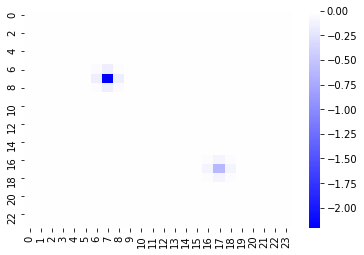

In [39]:
sns.heatmap(np.reshape(grad, (24,24)), cmap = cm.bwr, center = 0)

(576,)

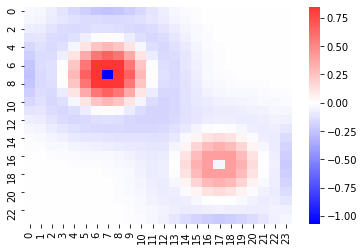

In [40]:
grad = L_grad_penalized(1000, L @ zf, len(vertices), kappa, c, t_of_v, vertices)
sns.heatmap(np.reshape(grad, (24,24)), cmap = cm.bwr, center = 0)
np.ravel(grad).shape

In [42]:
c = np.zeros(len(vertices))
grad = L_grad(len(vertices), kappa, c, t_of_v, vertices)
rate = 1.
new_zf = c + rate * grad
# this is the actual mesh we will plot
new_triangle_vertices = np.array([np.array([[xf[T[0]], yf[T[0]], new_zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], new_zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], new_zf[T[2]]]]) for T in triangles])
# vertices is the list of coordinates of each triangle
new_vertices = np.array(list(zip(xf, yf, new_zf)))
cv = np.array([vertex_curvature(v, t_of_v, new_vertices) for v in range(len(vertices))])

In [43]:
def objfn(kappa, c):
    diff = kappa-c
    diff = diff * diff
    return np.nansum(diff)

In [44]:
objfn(kappa, c)

18.638123335183174

In [45]:
objfn(kappa, c-0.001*grad)

18.618936721371156

In [59]:
# zf = 0.01 * z.flatten()
# zf = 0.001 * np.random.random(576)
zf = kappa.copy()
zf[np.isnan(zf)] = 0
vertices = np.array(list(zip(xf, yf, zf)))
cv = np.array([vertex_curvature(v, t_of_v, vertices) for v in range(len(vertices))])
rate = 0.0001
smooth_pen = 1
of = objfn(kappa, cv)
old_of = of

starting: rate: 5e-05 obj fn: 0.8032064482207466
step: 0, obj fn: 0.8031338913931805
step: 20, obj fn: 0.8017308341061711
step: 40, obj fn: 0.8004150809981724
step: 60, obj fn: 0.7991811950606906
step: 80, obj fn: 0.7980246661186398
step: 100, obj fn: 0.796941748441496
step: 120, obj fn: 0.7959293228423884
step: 140, obj fn: 0.7949847817369594
step: 160, obj fn: 0.7941059346474102
step: 180, obj fn: 0.7932909313357768
step: 200, obj fn: 0.7925381998185326
step: 220, obj fn: 0.791846396761612
step: 240, obj fn: 0.7912143680719184
step: 260, obj fn: 0.790641117828273
step: 280, obj fn: 0.7901257840009006
step: 300, obj fn: 0.7896676196808136
step: 320, obj fn: 0.7892659787746694
step: 340, obj fn: 0.7889203053180098
step: 360, obj fn: 0.7886301257235833
step: 380, obj fn: 0.7883950434159666
final: rate: 5e-05 obj fn: 0.7882224540903149


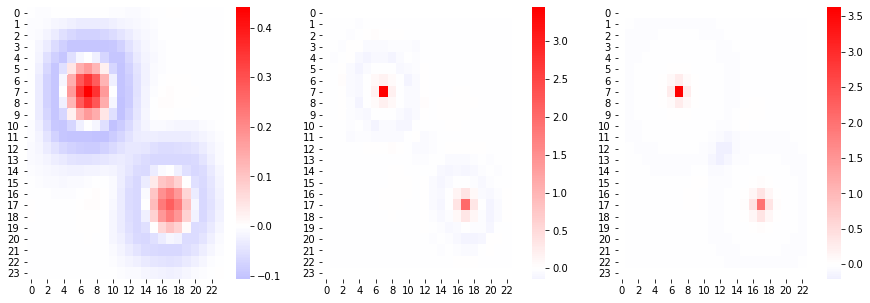

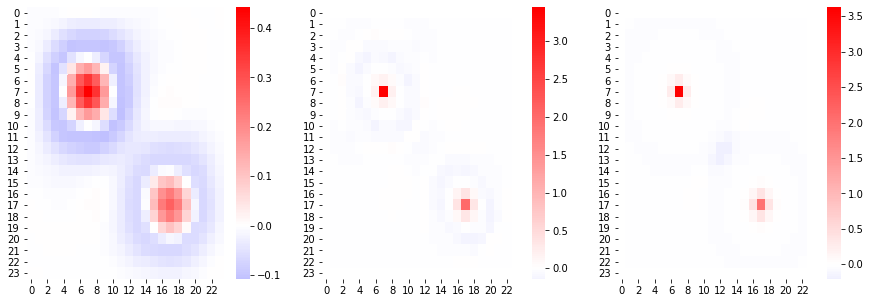

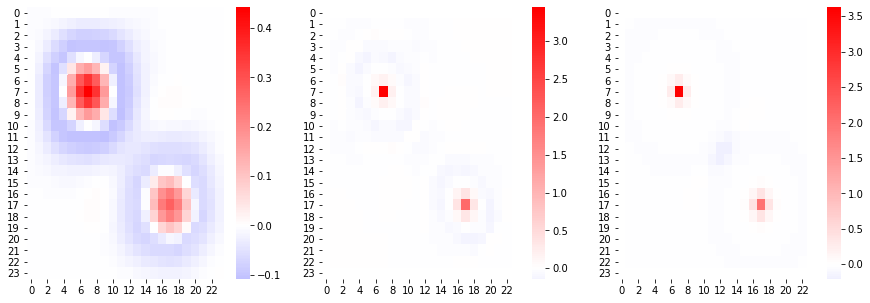

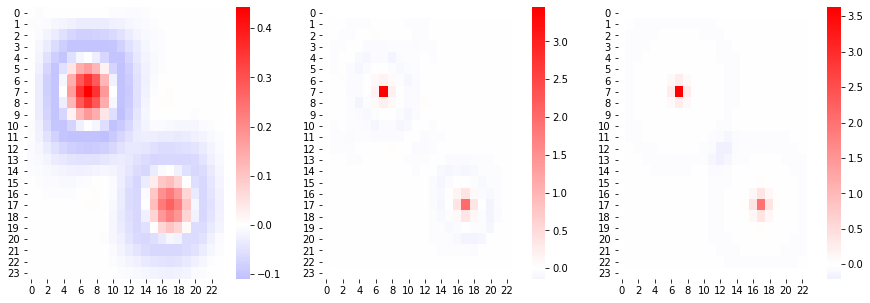

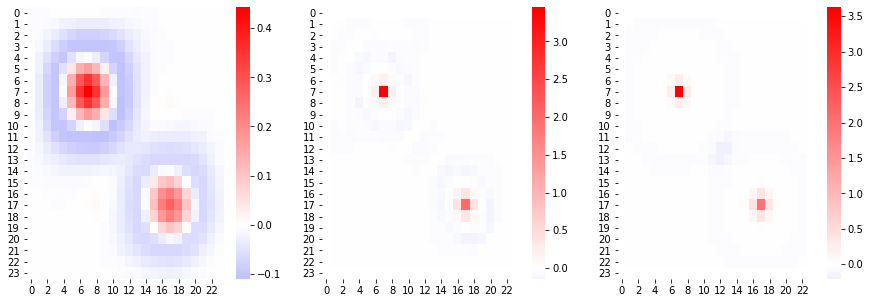

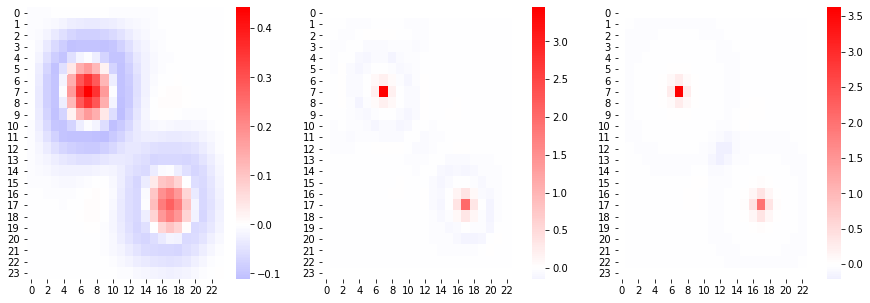

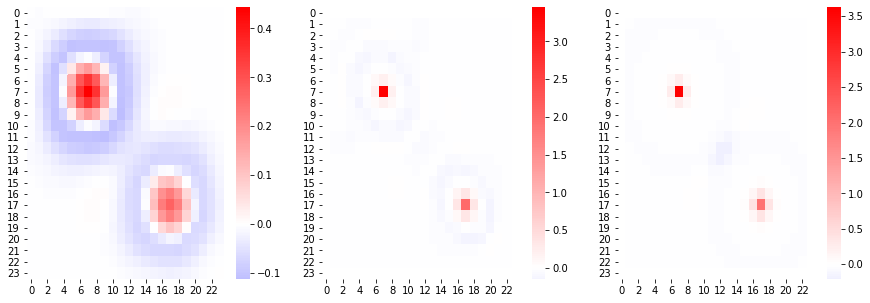

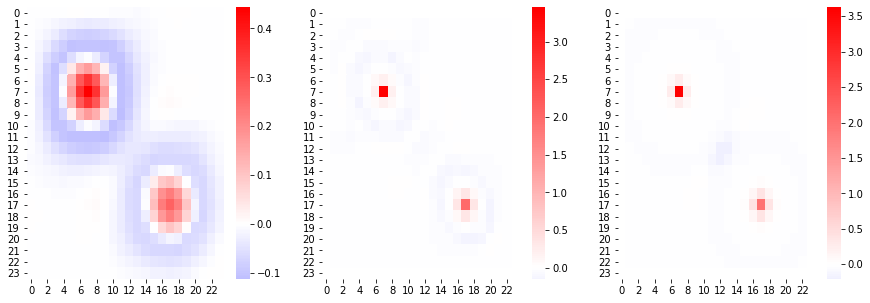

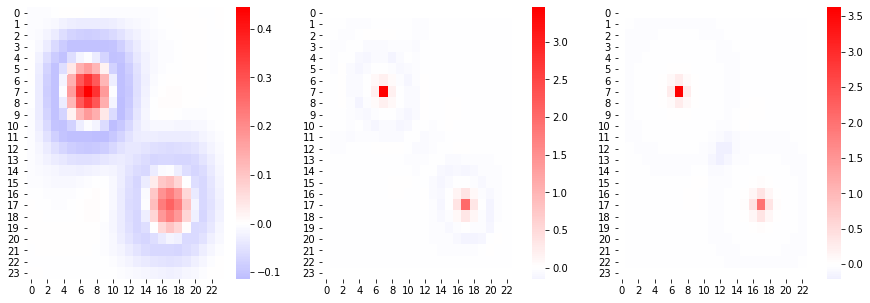

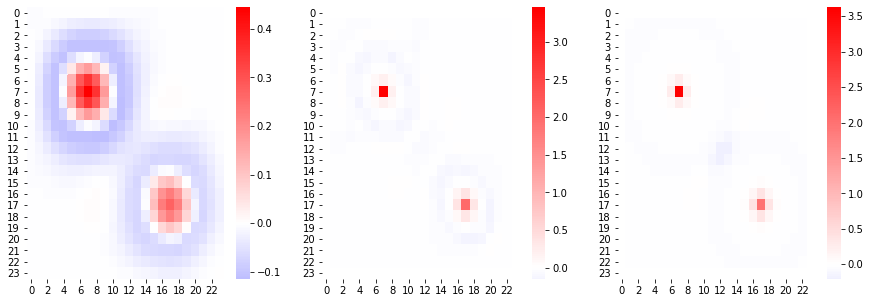

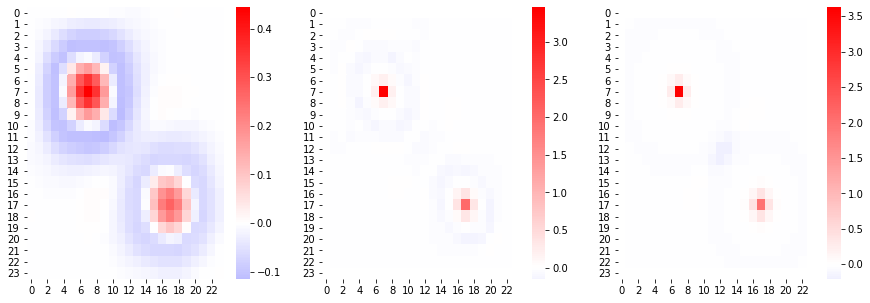

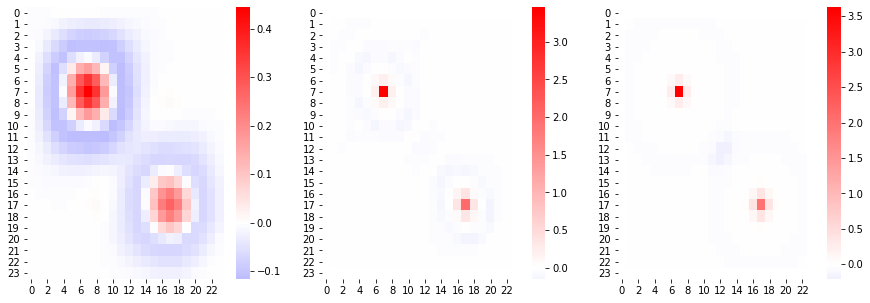

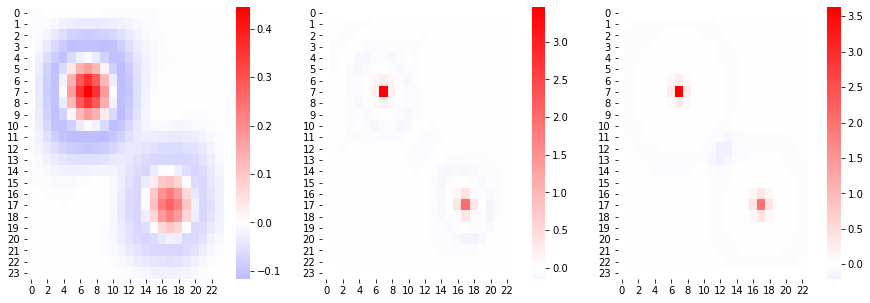

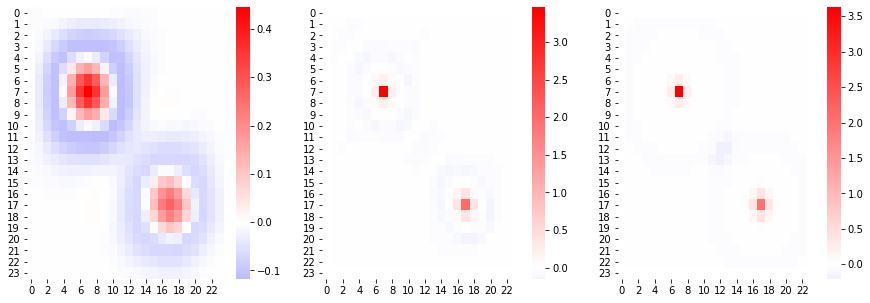

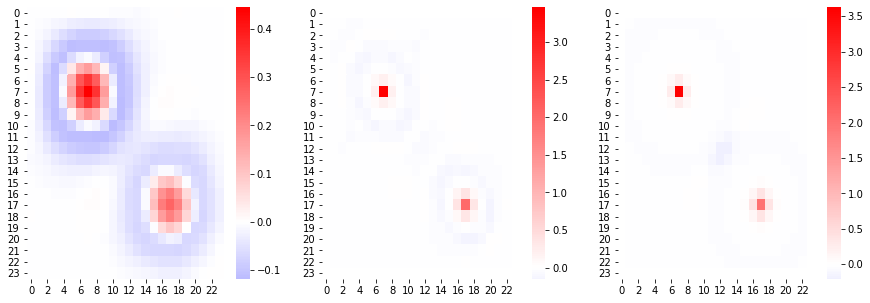

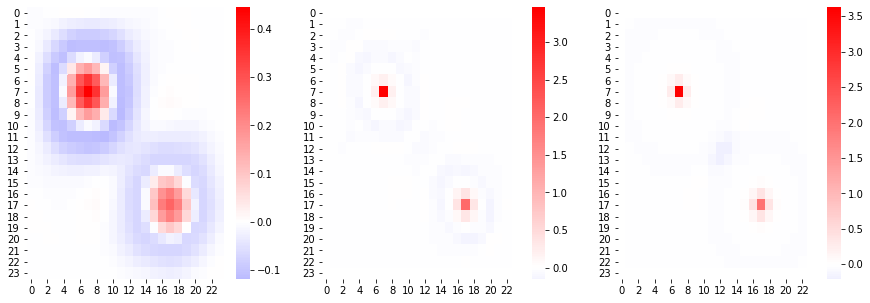

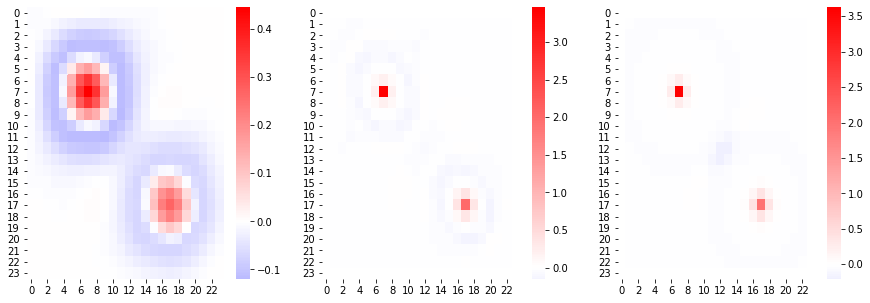

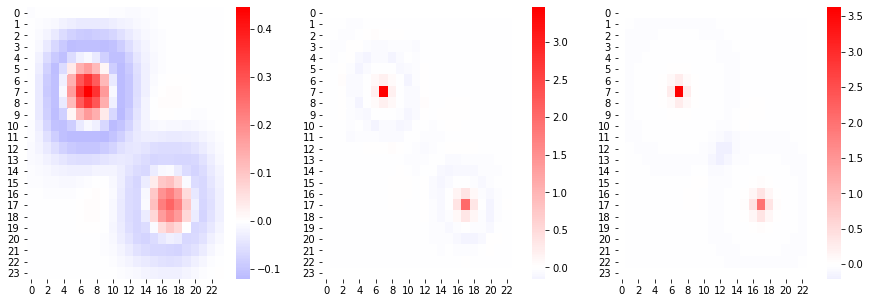

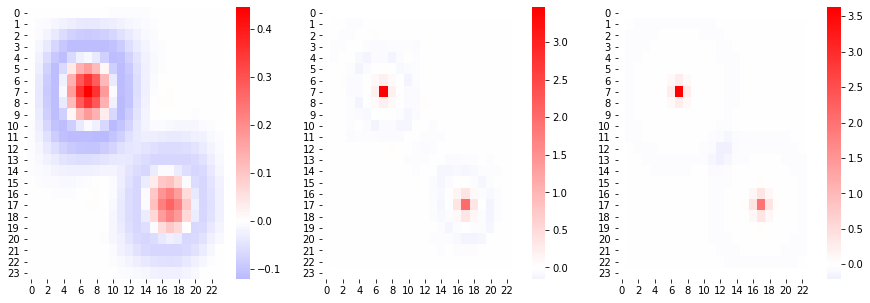

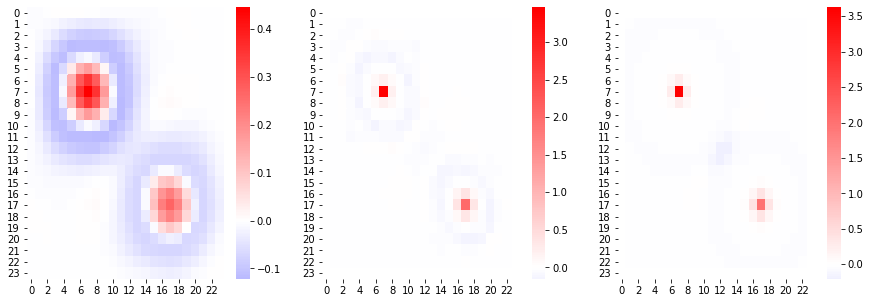

In [68]:
L3 = L @ L @ L

def single_step(smooth_pen, rate, vertices, kappa, cv_in, t_of_v, xf, yf, zf):
    grad = L_grad_penalized(smooth_pen, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad, penalty = L_grad_penalized_with_convexity(100, L, zf, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    # grad = L_grad_penalized_biased(10, 10, L3 @ zf, len(vertices), kappa, cv_in, t_of_v, vertices)
    new_zf = zf - rate * grad
    new_vertices = np.array(list(zip(xf, yf, new_zf)))
    new_cv = np.array([vertex_curvature(v, t_of_v, new_vertices) for v in range(len(vertices))])
    # new_cv[np.isnan(new_cv)] = 0.
    return new_zf, new_cv, new_vertices, grad

print('starting: rate: {} obj fn: {}'.format(rate, of))   
errvals = []

for i in range(400):
    new_zf, new_cv, new_vertices, new_grad = single_step(smooth_pen, rate, vertices, kappa, cv, t_of_v, xf, yf, zf)
    of = objfn(kappa, new_cv)
    # print('step: {} rate: {} obj fn: {}'.format(i, rate, of))
    if (of > old_of):
        print('step: {} -- lowering rate'.format(i))
        smooth_pen = smooth_pen / 2
        rate = rate / 2
    else:
        errvals.append(of)
        old_of = of
        zf = new_zf
        cv = new_cv
        vertices = new_vertices
        if (0 == i % 20):
            print('step: {}, obj fn: {}'.format(i, of))
            fig, axs = plt.subplots(1, 3, figsize=(15,5))
            sns.heatmap(np.reshape(new_zf, (24,24)), cmap = cm.bwr, center = 0, ax = axs[0])
            sns.heatmap(np.reshape(new_cv, (24,24)), cmap = cm.bwr, center = 0, ax = axs[1])
            sns.heatmap(np.reshape(kappa, (24,24)), cmap = cm.bwr, center = 0, ax = axs[2])
    

print('final: rate: {} obj fn: {}'.format(rate, of))

new_triangle_vertices = np.array([np.array([[xf[T[0]], yf[T[0]], new_zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], new_zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], new_zf[T[2]]]]) for T in triangles])


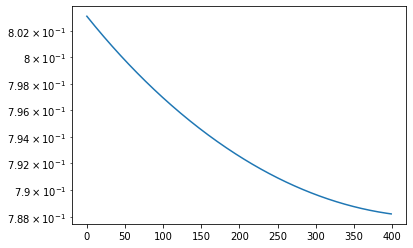

In [69]:
plt.plot(errvals, '-')
plt.yscale('log')

/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/markcrovella/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


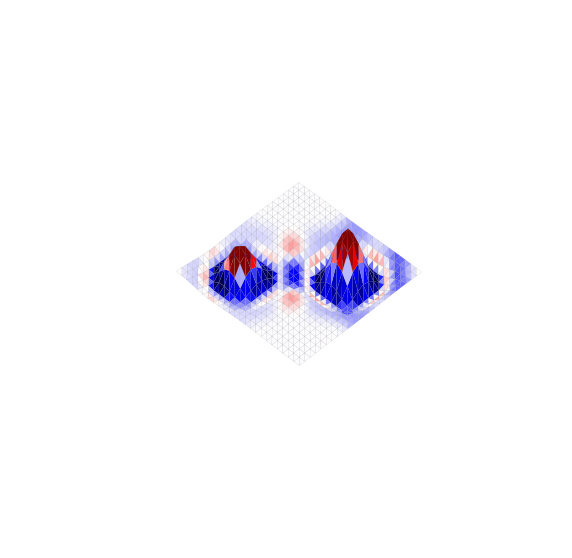

In [70]:
pcv = np.array([np.nanmean(cv[triangles[t]]) for t in range(len(triangles))])
maxscale = .1
# first, set all values above maxscale to maxscale 
pcv[pcv > maxscale] = maxscale
pcv[pcv < -maxscale] = -maxscale
facecolors = cmap([rmap(p, -maxscale, 0, maxscale, 1, 0.5) for p in pcv])
triangle_vertices = np.array([np.array([[xf[T[0]], yf[T[0]], zf[T[0]]],
                                    [xf[T[1]], yf[T[1]], zf[T[1]]],
                                    [xf[T[2]], yf[T[2]], zf[T[2]]]]) for T in triangles])
viz(triangle_vertices, facecolors)

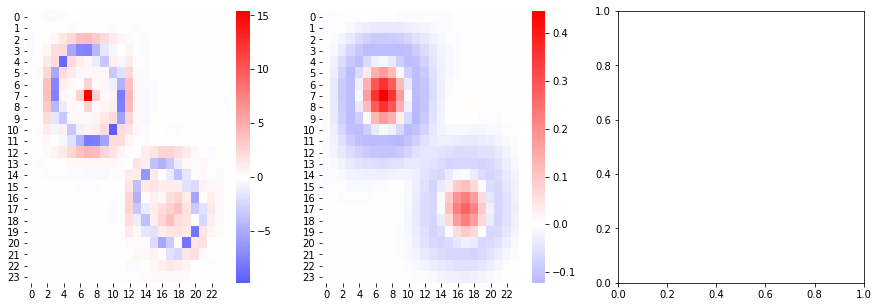

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.heatmap(np.reshape(L3@ new_zf, (24,24)), cmap = cm.bwr, center = 0, ax = axs[0])
sns.heatmap(np.reshape(new_zf, (24,24)), cmap = cm.bwr, center = 0, ax = axs[1])